In [ ]:
import numpy as np
from scipy.special import logsumexp
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import random
import itertools
import pandas as pd
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

# Set random seed
RAND = 0
torch.manual_seed(RAND)

# Dataloaders

In [ ]:
# MNIST
train_dataset = MNIST(root='../data', 
                      train=True, 
                      transform=transforms.ToTensor(),  
                      download=True)

test_dataset = MNIST(root='../data', 
                     train=False, 
                     transform=transforms.ToTensor(),
                     download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


In [ ]:
print(train_dataset.data.shape)
print(train_dataset.targets.shape)
print(test_dataset.data.shape)
print(test_dataset.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [ ]:
print(train_dataset[0][0].min())
print(train_dataset[0][0].max())
# Already scaled to 0-1
print(torch.unique(train_dataset.targets))
# Targets in their 0-9 form

tensor(0.)
tensor(1.)
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [ ]:
# To reduce debugging time
# train_dataset.targets = train_dataset.targets[:10000]
# train_dataset.data = train_dataset.data[:10000]

# Training Functions

In [ ]:
def random_search(hyperparameters, n_samples, RAND=None):
    keys_to_permut = []
    vals_to_permut = []
    for key, val in hyperparameters.items():
        if type(val) is tuple:
            keys_to_permut.append(key)
            vals_to_permut.append(val)

    vals_permut = itertools.product(*vals_to_permut)
    random.seed(RAND)
    samples = random.sample(list(vals_permut), n_samples)

    return samples, keys_to_permut


def set_hyperparameters_tune(config, tune, keys_iter):
    # Sets hyperparamters to selected tuning set
    for key in keys_iter:
        if key in config:
            config[key] = tune[key]
        else:
            raise ValueError("Key not in config dict")

    return config


def train_val_split(data, stratify=None, n_folds=1, RAND=None):
    """
    Uses StratifiedKFold for CV
    Returns an iterable [{train1, test1}, ...] for each split
    """

    it = []

    if type(n_folds) is float:
        # Loop through each class and multiply by the percentage to create the valid set
        # Get classes for stratified sampling
        classes = torch.unique(stratify)

        # Get index for each class
        test_index = []
        for c in classes:
            i_c = np.asarray((stratify == c).numpy()).nonzero()[0]
            class_test_size = int(np.round(len(i_c) * n_folds))
            test_index += list(i_c[random.sample(range(0, len(i_c)), class_test_size)])

        train_index = np.arange(data.targets.shape[0])
        train_index = np.delete(train_index, test_index)

        it = [{'train': Subset(data, train_index), 'test': Subset(data, test_index)}]
    else:
        kf = StratifiedKFold(n_splits=n_folds, random_state=RAND, shuffle=True)
        
        for train_index, test_index in kf.split(np.zeros(len(data)), stratify):
            it.append({'train': Subset(data, train_index), 'test': Subset(data, test_index)})

    return it


def kfoldCV(splits, config, plot_acc=False):
    all_train_acc = []
    all_val_acc = []
    all_metrics = []
    max_train_length = 0
    max_val_length = 0

    if plot_acc in ['per_split', 'norms']:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title('Training Accuracy')
        if plot_acc == 'norms':
            ax2.set_title('Average Gradient Norm')
        else:
            ax2.set_title('Validation Accuracy')
    elif plot_acc == 'mean':
        fig, ax1 = plt.subplots(1, 1)
        ax1.set_title('Accuracy')


    for i_split, split in enumerate(splits):
        if config['model_type'] == 'CNN':
            model = CNN(config).to(config['device'])
        elif config['model_type'] == 'MLP':
            model = MLP(config).to(config['device'])
        else:
            raise NotImplementedError("Did not implement models other than CNN or MLP")
        train_loader = DataLoader(split['train'], batch_size=config['batch_size'], shuffle=True)
        test_loader = DataLoader(split['test'], batch_size=config['batch_size'], shuffle=False)

        train_acc, val_acc = train_pytorch(train_loader, model, config, test_loader=test_loader)

        # Calculate final accuracy of fitted model
        if config['early_stopping']:
            # Take the early_stopping point which is the min of 1-accuracy
            final_val_acc = min(val_acc)
        else:
            # The last value is the final accuracy of the model
            final_val_acc = val_acc[-1]

        # Plot loss curves    
        if plot_acc == 'per_split' or plot_acc == 'norms':
            ax1.plot(train_acc, label='Split ' + str(i_split))
            ax2.plot(val_acc, label='Split ' + str(i_split))

        if len(train_acc) > max_train_length:
            max_train_length = len(train_acc)
        if len(val_acc) > max_val_length:
            max_val_length = len(val_acc)

        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)
        all_metrics.append(final_val_acc)


    # Plot loss curves
    if plot_acc == 'mean':
        # Pad the loss curves with NaNs so they have equal length for nanmean
        all_train_acc = [[l[i] if i < len(l) else np.NaN for i in range(max_train_length)] for l in all_train_acc]
        all_val_acc = [[l[i] if i < len(l) else np.NaN for i in range(max_val_length)] for l in all_val_acc]
        train_mean_acc = np.nanmean(all_train_acc, axis=0)
        val_mean_acc = np.nanmean(all_val_acc, axis=0)
        train_std_acc = np.nanstd(all_train_acc, axis=0)
        val_std_acc = np.nanstd(all_val_acc, axis=0)
        # Plot
        ax1.plot(train_mean_acc, label='Training Accuracy')
        ax1.fill_between(np.arange(max_train_length), train_mean_acc + train_std_acc, train_mean_acc - train_std_acc,
                         alpha=0.1)
        ax1.plot(val_mean_acc, label='Validation Accuracy')
        ax1.fill_between(np.arange(max_val_length), val_mean_acc + val_std_acc, val_mean_acc - val_std_acc, alpha=0.1)

    if plot_acc and plot_acc not in ['confusion_matrix', 'per_tune']:
        plt.legend()
        plt.show()

    # Take mean CV metric
    avg_metric = np.mean(all_metrics)

    if config['max_epochs'] is not None:
        max_epochs = max_val_length
    else:
        max_epochs = round(max_val_length * len(split['train']) / config['batch_size'])

    return avg_metric, max_epochs, val_acc


def tuning_loop(splits, samples, keys, config, verbose=False, plot_acc=False):
    all_metrics = []
    all_max_epochs = []
    results_experiment = {}

    if plot_acc == 'per_tune':
        if len(splits) > 1:
            raise AssertionError("Not clear what to plot if more than one validation set")
        fig, ax1 = plt.subplots(1, 1)
        ax1.set_title('Validation Accuracy')
        ax1.set_ylabel('Classification Error (%)')
        ax1.set_xlabel('Epochs')
        ax1.set_ylim(0.8, 3.0)

    # Loop through each set of hyperparameters
    for i, params in enumerate(samples):
        # Recreate a dict format for parameters
        tune = {key: val for key, val in zip(keys, params)}
        config = set_hyperparameters_tune(config.copy(), tune, keys)

        # initialize model
        metric, max_epoch, val_acc = kfoldCV(splits, config, plot_acc=plot_acc)
        all_metrics.append(metric)
        all_max_epochs.append(max_epoch)

        # Plot loss curves
        if plot_acc == 'per_tune':
            ax1.plot(np.array(val_acc)*100, label='Model ' + str(i))

        # Print metric
        if verbose:
            print("\nHyperparameters:")
            print(config)
            print("Accuracy: %.4g" % (all_metrics[-1],))
            results_experiment[", ".join("=".join((str(k), str(v))) for k, v in config.items())] = all_metrics[-1]


    if plot_acc == 'per_tune':
        plt.legend()
        plt.tight_layout()
        plt.savefig("per_tune_dropout_vs_dropout_maxnorm.png")
        plt.show()

    i_best = np.argmin(all_metrics)
    best_samples = samples[i_best]
    # Recreate a dict format for parameters
    best_params = {key: val for key, val in zip(keys, best_samples)}
    best_params = set_hyperparameters_tune(config.copy(), best_params, keys)
    # Add max early stop epoch as the new best epoch parameter and turn early stopping to False
    best_params['early_stopping'] = False
    if best_params['max_epochs'] is not None:
        best_params['max_epochs'] = all_max_epochs[i_best]
    else:
        best_params['max_steps'] = all_max_epochs[i_best]
    best_metric = np.min(all_metrics)

    if verbose:
        print('\nBest hyperparameters:')
        print(best_params)
        print('Best average validation metric: %.4g' % (best_metric,))
        pd.DataFrame(results_experiment.items()).to_excel("table9_l2.xlsx")

    return best_params, best_metric


def train_test(train_dataset, test_dataset, config, RAND, k_folds=5, random_search_samples=50, verbose=False, plot_acc=False):
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    config['device'] = device
    
    # Load K-fold splits
    if k_folds is not None:
        splits = train_val_split(train_dataset, stratify=train_dataset.targets, n_folds=k_folds, RAND=RAND)

        print("Tuning MLP on training set:")
        samples, keys = random_search(config, n_samples=random_search_samples, RAND=RAND)
        best_params, best_metric = tuning_loop(splits, samples, keys, config, verbose=verbose, plot_acc=plot_acc)
    else:
        best_params = config

    # Final test set using best hyperparameters
    if best_params['model_type'] == 'CNN':
        model = CNN(best_params).to(config['device'])
    elif best_params['model_type'] == 'MLP':
        model = MLP(best_params).to(config['device'])
    else:
        raise NotImplementedError("Did not implement models other than CNN or MLP")

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                       batch_size=best_params['batch_size'],
                                       shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=best_params['batch_size'],
                                              shuffle=False)

    train_pytorch(train_loader, model, best_params)

    # Calculate final accuracy of fitted model
    model.eval()
    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
        y_pred_all = []
        y_true_all = []
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(config['device'])
            y_batch = y_batch.to(config['device'])

            y_true_all += y_batch.cpu().numpy().tolist()
            y_pred = model(X_batch)

            y_pred_prob = softmax(y_pred)
            y_pred_tag = torch.max(y_pred_prob, dim=1).indices

            y_pred_all += y_pred_tag.cpu().numpy().tolist()

        test_acc = evaluate_acc(np.array(y_true_all), np.array(y_pred_all))

    print('Test accuracy using best hyperparameters: %.4g' % (test_acc,))
    results_experiment = {}
    results_experiment[", ".join("=".join((str(k), str(v))) for k, v in best_params.items())] = test_acc
    pd.DataFrame(results_experiment.items()).to_excel("table9_l2_test.xlsx")

class EarlyStop():
    def __init__(self, patience=10, reverse=False):
        # Set reverse to True if a better metric is a larger one, False if opposite
        self.best_metric = None
        self.best_weights = None
        self.reverse = reverse
        self.patience = patience
        self.latency = 0

    def update_metric(self, valid_metric, weights):
        update = False
        early_stop = False
        if self.best_metric is None:
            self.best_metric = valid_metric
            self.best_weights = weights
            update = True
        elif self.reverse:
            if self.best_metric < valid_metric:
                self.best_metric = valid_metric
                self.best_weights = weights
                update = True
        else:
            if self.best_metric > valid_metric:
                self.best_metric = valid_metric
                self.best_weights = weights
                update = True
        if not update:
            if self.latency == self.patience:
                early_stop = True  # Early stop
            else:
                self.latency += 1  # Continue until patience
        else:
            early_stop = False  # Since just updated best_metric, continue until patience
            self.latency = 0  # Reset latency
        return early_stop


def evaluate_acc(true_y, target_y):
    # The dropout paper presents errors, not accuracy, so do 1-accuracy
    return 1 - np.sum(target_y == true_y)/true_y.shape[0]


def max_norm(model, max_val=3):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'bias' not in name:
                norm = param.norm(2, dim=0, keepdim=True)  # Compute L2 norm for all weights
                scale = torch.clamp(norm, 0, max_val)  # Clamp norms to desired max val
                param *= (scale / norm)  # Rescale the parameters so the new norm = max_val


def train_pytorch(train_loader, model, config, test_loader=None):
    if config['epsilon_decay']:
        lr = config['base_epsilon']
    else:
        lr = config['learning_rate']

    if config['momentum_decay']:
        momentum = config['initial_momentum']
    else:
        momentum = config['momentum']

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=config['L2_regularization_param'])
    criterion = nn.CrossEntropyLoss()
    softmax = nn.Softmax(dim=1)

    # Setup Early Stopping
    early_stop = EarlyStop(patience=10, reverse=True)
    train_acc = []
    val_acc = []
    running_ap = 0.0
    beta = 0.9

    epoch = 0 # Epoch count
    step = 0  # Step count

    if config['max_epochs'] is not None and config['max_steps'] is not None:
        raise AssertionError("Need to specify one or the other, but not both.")

    if config['max_epochs'] is not None:
        max_it = config['max_epochs']
    else:
        max_it = config['max_steps']

    i = 0

    pbar = tqdm(total=max_it)
    while i <= max_it:

        # --- Train ---
        model.train()
        y_pred_all = []
        y_true_all = []
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(config['device'])
            y_batch = y_batch.to(config['device'])

            y_true_all += y_batch.cpu().numpy().tolist()
            y_batch = y_batch.long()
            y_pred = model(X_batch)

            y_pred_prob = softmax(y_pred)
            y_pred_tag = torch.max(y_pred_prob, dim=1).indices

            y_pred_all += y_pred_tag.cpu().numpy().tolist()
            loss = criterion(y_pred, y_batch)
            # Add L1 "towards the end of training"
            if config['L1_regularization_param'] > 0:
                if step > config['L1_start_step']:
                    L1 = torch.tensor(0., requires_grad=True)
                    for name, param in model.named_parameters():
                        if 'weight' in name:
                            L1 = L1 + torch.norm(param, 1)

                    loss = loss + config['L1_regularization_param'] * L1

            # Add a KL sparsity penalty
            if config['kl_sparsity_beta']:
                loss = loss + config['kl_sparsity_beta'] * model.kl_div


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            if config['max_norm'] is not None:
                max_norm(model, config['max_norm'])

            if config['epsilon_decay']:
                epsilon = get_epsilon(step, config)
                update_optim(optimizer, epsilon, 'lr')
            
            if config['momentum_decay']:
                momentum = get_momentum(step, config)
                update_optim(optimizer, momentum, 'momentum')

            step += 1
            if config['max_steps'] is not None and step >= config['max_steps']:
                break

        train_acc.append(evaluate_acc(np.array(y_true_all), np.array(y_pred_all)))

        # --- Validate ---
        model.eval()
        with torch.no_grad():
            if test_loader is not None:
                y_pred_all = []
                y_true_all = []
                for X_batch, y_batch in test_loader:
                    X_batch = X_batch.to(config['device'])
                    y_batch = y_batch.to(config['device'])

                    y_true_all += y_batch.cpu().numpy().tolist()
                    y_pred = model(X_batch)

                    y_pred_prob = softmax(y_pred)
                    y_pred_tag = torch.max(y_pred_prob, dim=1).indices

                    y_pred_all += y_pred_tag.cpu().numpy().tolist()

                val_acc.append(evaluate_acc(np.array(y_true_all), np.array(y_pred_all)))

                # Update moving average
                if epoch == 0:
                    running_ap = val_acc[-1]
                else:
                    running_ap = beta * running_ap + (1 - beta) * val_acc[-1]

                # early stop
                if config['early_stopping']:
                    if early_stop.update_metric(running_ap, model.state_dict()):
                        # Save best weights
                        model.load_state_dict(early_stop.best_weights)
                        break

        epoch += 1

        if config['max_epochs'] is not None:
            pbar.update(n=epoch - i)
            i = epoch
        else:
            pbar.update(n=step - i)
            i = step

    pbar.close()

    return train_acc, val_acc


def kl_div(r, r_hat, epsilon=1e-6):
    r_hat = torch.mean(torch.clamp(r_hat, min=epsilon, max=1 - epsilon), 0)  # maximum to constrain rho between 0 and 1
    r = torch.Tensor([r] * len(r_hat)).to(r_hat.device)
    return torch.sum(r * torch.log(r / r_hat) + (1 - r) * torch.log((1 - r) / (1 - r_hat)))


def update_optim(optim, param_val, param_name):
    """Updates the momentum/lr manually for each parameter group in the optimizer"""
    for g in optim.param_groups:
          g[param_name] = param_val

def get_momentum(step, config):
    """
    ***Adapted from: https://github.com/nitishsrivastava/deepnet/blob/f4e4ff207923e01552c96038a1e2c29eb5d16160/deepnet/parameter.py
    """
    momentum = config['final_momentum'] - (config['final_momentum'] - config['initial_momentum'])*np.exp(-float(step)/config['momentum_change_steps'])
    
    return momentum

def get_epsilon(step, config):
    """
    ***Adapted from: https://github.com/nitishsrivastava/deepnet/blob/f4e4ff207923e01552c96038a1e2c29eb5d16160/deepnet/parameter.py
    """
    epsilon = config['base_epsilon']
    if config['epsilon_decay'] == 'INVERSE_T':
      epsilon = config['base_epsilon'] / (1 + float(step) / config['epsilon_decay_half_life'])
    elif config['epsilon_decay'] == 'EXPONENTIAL':
      epsilon = config['base_epsilon'] / np.power(2, float(step) / config['epsilon_decay_half_life'])

    return epsilon

# Models

In [ ]:
class MLP(nn.Module):
    def __init__(self, config):
        super(MLP, self).__init__()

        # Set up layers
        self.h_layer = nn.ModuleList([nn.Linear(config['D_in'], d) if i == 0 else nn.Linear(config['D_h'][i - 1], d) for i, d in enumerate(config['D_h'])])
        self.out_layer = nn.Linear(config['D_h'][-1], config['D_out'])

        # Put each dropout layer in a ModuleList to enable different p for each layer
        dropout_list = []
        for p in config['dropout']:
            dropout_list.append(nn.Dropout(p=p))
        self.dropout_layers = nn.ModuleList(dropout_list)

        self.activation = eval('nn.' + config['activation'])()

        self.kl_sparsity = config['kl_sparsity']
        self.kl_div = torch.tensor(0., requires_grad=True)

    def forward(self, x):
        x = x.view(-1, 28*28)
        self.kl_div = torch.tensor(0., requires_grad=True)
        for i, l in enumerate(self.h_layer):
            x = self.activation(l(x))
            if self.kl_sparsity is not None:
               self.kl_div = self.kl_div + kl_div(self.kl_sparsity, x)

            if i > len(self.dropout_layers) - 1:
                # Assume the last value of the dropout list is meant for all layers
                x = self.dropout_layers[-1](x)
            else:
                # Use the layer specific dropout value
                x = self.dropout_layers[i](x)

        out = self.out_layer(x)

        return out

# Experiment Setup (Example)

In [ ]:
# Set hyperparameters
config = {
    'batch_size': 264,
    'early_stopping': True,
    'max_epochs': 500,
    'momentum': 0.95,
    'momentum_decay': True, # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000, # Number of steps at which 'final_momentum' is set
    'learning_rate': 0.1, # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL', # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': 0.1,
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0,),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.5, 0.9, 0.9], # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': X_train.shape[1],
    'D_h': ([0],), # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,), # Number of classes
    'max_norm': (2,),  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'CNN' # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=0.1, random_search_samples=1, verbose=True, plot_acc=False)

NameError: ignored

# Table 2

In [ ]:
# Table 2: neural network ReLU
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1, 0.01),
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0,),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.0],  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': ([800, 800], [800, 800, 800], [1024, 1024], [1024, 1024, 1024], [2048, 2048], [2048, 2048, 2048]),  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,),  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=12, verbose=True, plot_acc=False)

In [ ]:
# Table 2: neural network Sigmoid
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1, 0.01),
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0,),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.0],  # Implement your models with each layer's p in a list
    'activation': 'Sigmoid',
    'D_in': 784,
    'D_h': ([800, 800], [800, 800, 800], [1024, 1024], [1024, 1024, 1024], [2048, 2048], [2048, 2048, 2048]),  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,),  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=12, verbose=True, plot_acc=False)

In [ ]:
# Table 2: neural network with dropout ReLU
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1, 0.01),
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0,),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.2, 0.5],  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': ([800, 800], [800, 800, 800], [1024, 1024], [1024, 1024, 1024], [2048, 2048], [2048, 2048, 2048]),  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,),  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=12, verbose=True, plot_acc=False)

In [ ]:
# Table 2: neural network with dropout Sigmoid
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1, 0.01),
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0,),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.2, 0.5],  # Implement your models with each layer's p in a list
    'activation': 'Sigmoid',
    'D_in': 784,
    'D_h': ([800, 800], [800, 800, 800], [1024, 1024], [1024, 1024, 1024], [2048, 2048], [2048, 2048, 2048]),  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,),  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=12, verbose=True, plot_acc=False)

In [ ]:
# Table 2: neural network with dropout + max-norm ReLU
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1, 0.01),
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0,),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.2, 0.5],  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': ([800, 800], [800, 800, 800], [1024, 1024], [1024, 1024, 1024], [2048, 2048], [2048, 2048, 2048]),  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,),  # Number of classes
    'max_norm': (4, 3.5, 3),  # (4, 3, 2, 1, 0.5, None) # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=24, verbose=True, plot_acc=False)

# Figure 4

In [ ]:
# Figure 4 v1: ReLU
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': 0.01,
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0,),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': ([0.2, 0.5], [0.0]),  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': ([1024, 1024], [1024, 1024, 1024], [1024, 1024, 1024, 1024], [2048, 2048], [2048, 2048, 2048], [2048, 2048, 2048, 2048]),  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,),  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=12, verbose=True, plot_acc='per_tune')

In [ ]:
# Figure 4 v2: Sigmoid
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': 0.01,
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0,),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': ([0.2, 0.5], [0.0]),  # Implement your models with each layer's p in a list
    'activation': 'Sigmoid',
    'D_in': 784,
    'D_h': ([1024, 1024], [1024, 1024, 1024], [1024, 1024, 1024, 1024], [2048, 2048], [2048, 2048, 2048], [2048, 2048, 2048, 2048]),  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,),  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=12, verbose=True, plot_acc='per_tune')

In [ ]:
# Figure 4 extra: L2 alone with 0.01
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': 0.01,
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': 0.0001,
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.0],  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': ([1024, 1024], [1024, 1024, 1024], [1024, 1024, 1024, 1024], [2048, 2048], [2048, 2048, 2048], [2048, 2048, 2048, 2048]),  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': 10,  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=6, verbose=True, plot_acc='per_tune')

In [ ]:
# Figure 4 extra: Dropout alonewith 0.01
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': 0.01,
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': 0.0,
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.2, 0.5],  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': ([1024, 1024], [1024, 1024, 1024], [1024, 1024, 1024, 1024], [2048, 2048], [2048, 2048, 2048], [2048, 2048, 2048, 2048]),  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': 10,  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=6, verbose=True, plot_acc='per_tune')

# Table 9

In [ ]:
# L2
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1, 0.01),
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0.1, 0.01, 0.001, 0.0001),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.0],  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': [1024, 1024, 2048],  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': 10,  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None) # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=8, verbose=True, plot_acc=False)

  0%|          | 0/200000 [00:00<?, ?it/s]

Tuning MLP on training set:


200001it [30:03, 110.91it/s]                            
  0%|          | 0/200000 [00:00<?, ?it/s]


Hyperparameters:
{'batch_size': 100, 'early_stopping': False, 'max_epochs': None, 'max_steps': 200000, 'momentum': None, 'momentum_decay': True, 'initial_momentum': 0.5, 'final_momentum': 0.95, 'momentum_change_steps': 20000, 'learning_rate': None, 'epsilon_decay': 'EXPONENTIAL', 'base_epsilon': 0.01, 'epsilon_decay_half_life': 100000, 'L2_regularization_param': 0.001, 'dropout': [0.0], 'activation': 'ReLU', 'D_in': 784, 'D_h': [1024, 1024, 2048], 'D_out': 10, 'max_norm': None, 'model_type': 'MLP', 'device': device(type='cuda', index=0)}
Accuracy: 0.021


200001it [29:56, 111.35it/s]                            
  0%|          | 0/200000 [00:00<?, ?it/s]


Hyperparameters:
{'batch_size': 100, 'early_stopping': False, 'max_epochs': None, 'max_steps': 200000, 'momentum': None, 'momentum_decay': True, 'initial_momentum': 0.5, 'final_momentum': 0.95, 'momentum_change_steps': 20000, 'learning_rate': None, 'epsilon_decay': 'EXPONENTIAL', 'base_epsilon': 0.01, 'epsilon_decay_half_life': 100000, 'L2_regularization_param': 0.0001, 'dropout': [0.0], 'activation': 'ReLU', 'D_in': 784, 'D_h': [1024, 1024, 2048], 'D_out': 10, 'max_norm': None, 'model_type': 'MLP', 'device': device(type='cuda', index=0)}
Accuracy: 0.0203


200001it [29:54, 111.43it/s]                            
  0%|          | 0/200000 [00:00<?, ?it/s]


Hyperparameters:
{'batch_size': 100, 'early_stopping': False, 'max_epochs': None, 'max_steps': 200000, 'momentum': None, 'momentum_decay': True, 'initial_momentum': 0.5, 'final_momentum': 0.95, 'momentum_change_steps': 20000, 'learning_rate': None, 'epsilon_decay': 'EXPONENTIAL', 'base_epsilon': 0.1, 'epsilon_decay_half_life': 100000, 'L2_regularization_param': 0.0001, 'dropout': [0.0], 'activation': 'ReLU', 'D_in': 784, 'D_h': [1024, 1024, 2048], 'D_out': 10, 'max_norm': None, 'model_type': 'MLP', 'device': device(type='cuda', index=0)}
Accuracy: 0.0156


200001it [30:03, 110.92it/s]                            
  0%|          | 0/200000 [00:00<?, ?it/s]


Hyperparameters:
{'batch_size': 100, 'early_stopping': False, 'max_epochs': None, 'max_steps': 200000, 'momentum': None, 'momentum_decay': True, 'initial_momentum': 0.5, 'final_momentum': 0.95, 'momentum_change_steps': 20000, 'learning_rate': None, 'epsilon_decay': 'EXPONENTIAL', 'base_epsilon': 0.1, 'epsilon_decay_half_life': 100000, 'L2_regularization_param': 0.1, 'dropout': [0.0], 'activation': 'ReLU', 'D_in': 784, 'D_h': [1024, 1024, 2048], 'D_out': 10, 'max_norm': None, 'model_type': 'MLP', 'device': device(type='cuda', index=0)}
Accuracy: 0.8876


200001it [30:08, 110.57it/s]                            
  0%|          | 0/200000 [00:00<?, ?it/s]


Hyperparameters:
{'batch_size': 100, 'early_stopping': False, 'max_epochs': None, 'max_steps': 200000, 'momentum': None, 'momentum_decay': True, 'initial_momentum': 0.5, 'final_momentum': 0.95, 'momentum_change_steps': 20000, 'learning_rate': None, 'epsilon_decay': 'EXPONENTIAL', 'base_epsilon': 0.1, 'epsilon_decay_half_life': 100000, 'L2_regularization_param': 0.001, 'dropout': [0.0], 'activation': 'ReLU', 'D_in': 784, 'D_h': [1024, 1024, 2048], 'D_out': 10, 'max_norm': None, 'model_type': 'MLP', 'device': device(type='cuda', index=0)}
Accuracy: 0.0331


200001it [30:01, 111.00it/s]                            
  0%|          | 0/200000 [00:00<?, ?it/s]


Hyperparameters:
{'batch_size': 100, 'early_stopping': False, 'max_epochs': None, 'max_steps': 200000, 'momentum': None, 'momentum_decay': True, 'initial_momentum': 0.5, 'final_momentum': 0.95, 'momentum_change_steps': 20000, 'learning_rate': None, 'epsilon_decay': 'EXPONENTIAL', 'base_epsilon': 0.01, 'epsilon_decay_half_life': 100000, 'L2_regularization_param': 0.01, 'dropout': [0.0], 'activation': 'ReLU', 'D_in': 784, 'D_h': [1024, 1024, 2048], 'D_out': 10, 'max_norm': None, 'model_type': 'MLP', 'device': device(type='cuda', index=0)}
Accuracy: 0.0449


200001it [29:55, 111.40it/s]                            
  0%|          | 0/200000 [00:00<?, ?it/s]


Hyperparameters:
{'batch_size': 100, 'early_stopping': False, 'max_epochs': None, 'max_steps': 200000, 'momentum': None, 'momentum_decay': True, 'initial_momentum': 0.5, 'final_momentum': 0.95, 'momentum_change_steps': 20000, 'learning_rate': None, 'epsilon_decay': 'EXPONENTIAL', 'base_epsilon': 0.1, 'epsilon_decay_half_life': 100000, 'L2_regularization_param': 0.01, 'dropout': [0.0], 'activation': 'ReLU', 'D_in': 784, 'D_h': [1024, 1024, 2048], 'D_out': 10, 'max_norm': None, 'model_type': 'MLP', 'device': device(type='cuda', index=0)}
Accuracy: 0.06909


 31%|███▏      | 62500/200000 [09:22<20:34, 111.42it/s]

In [ ]:
# L2 + L1 applied towards the end of training
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1, 0.01),
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0.1, 0.01, 0.001, 0.0001),
    'L1_regularization_param': (0.1, 0.01, 0.001, 0.0001),
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.0],  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': [1024, 1024, 2048],  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': 10,  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None) # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=24, verbose=True, plot_acc=False)

In [ ]:
# L2 + KL sparsity
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1, 0.01),
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0.1, 0.01, 0.001, 0.0001),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': 0.05,  # KL Sparsity rho
    'kl_sparsity_beta': (0.1, 0.01, 0.001, 0.0001),  # beta coefficient for regularization term
    'dropout': [0.0],  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': [1024, 1024, 2048],  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': 10,  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None) # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=32, verbose=True, plot_acc=False)

In [ ]:
# Max-norm
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1, 0.01),
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': 0.0, # (0.1, 0.01, 0.001, 0.0001),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.0],  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': [1024, 1024, 2048],  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': 10,  # Number of classes
    'max_norm': (4, 3.5, 3),  # (4, 3, 2, 1, 0.5, None) # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=6, verbose=True, plot_acc=False)

In [ ]:
# Dropout + L2
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1, 0.01),
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': (0.1, 0.01, 0.001, 0.0001), # (0.1, 0.01, 0.001, 0.0001),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.2, 0.5],  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': [1024, 1024, 2048],  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': 10,  # Number of classes
    'max_norm': None,  # (4, 3, 2, 1, 0.5, None) # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=8, verbose=True, plot_acc=False)

In [ ]:
# Dropout + Max-norm
config = {
    'batch_size': 100,
    'early_stopping': False,
    'max_epochs': None,  # If None need to specify max_steps
    'max_steps': 200000,  # If None need to specify max_epochs
    'momentum': None,
    'momentum_decay': True,  # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': 0.5,
    'final_momentum': 0.95,
    'momentum_change_steps': 20000,  # Number of steps at which 'final_momentum' is set
    'learning_rate': None,  # (0.25, 1e-1, 1e-2),
    'epsilon_decay': 'EXPONENTIAL',  # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1, 0.01),
    'epsilon_decay_half_life': 100000,
    'L2_regularization_param': 0.0, # (0.1, 0.01, 0.001, 0.0001),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': [0.2, 0.5],  # Implement your models with each layer's p in a list
    'activation': 'ReLU',
    'D_in': 784,
    'D_h': [1024, 1024, 2048],  # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': 10,  # Number of classes
    'max_norm': (4, 3.5, 3),  # (4, 3, 2, 1, 0.5, None) # Max norm contraint from dropout paper on the weights
    'model_type': 'MLP'  # MLP or CNN
}
train_test(train_dataset, test_dataset, config, RAND, k_folds=1/6, random_search_samples=6, verbose=True, plot_acc=False)

# Additional Results 1 - Ablation study

**MODEL A**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

input_size = 784
hidden_size = 1024
num_classes = 10


class CustomDropout(nn.Module):
    def __init__(self, p=0.5, prob_mask_prop=0.5,  method='standard'):
        super(CustomDropout, self).__init__()
        #prob_mask_prop = probabilistic mask proportion of the layer (0 to 1)
        self.p = p
        self.prob_mask_prop = prob_mask_prop
        self.method = method

    def forward(self, input):
        #print(input.size())
        batch_s,wide_layer = input.size()
        prob_layer_size = round(wide_layer*self.prob_mask_prop)

        if self.training:
          if self.method == 'standard':
            prob_mask = torch.distributions.bernoulli.Bernoulli(1-self.p).sample([batch_s,prob_layer_size  ]).to(device='cuda')
            prob_mask = prob_mask* (1.0/(1-self.p))
          else:
            prob_mask = torch.randn(batch_s,prob_layer_size, requires_grad=False).to(device='cuda')   
            prob_mask = prob_mask* (self.p/(1-self.p)) + 1 
          fix_part = torch.ones(batch_s, wide_layer - prob_layer_size, requires_grad=False).to(device='cuda')
          final_mask = torch.cat((prob_mask, fix_part), 1)

          return input * final_mask
        else:
          return input

    def __repr__(self):
        prob_mask_prop_str = ''+str(self.prob_mask_prop) if self.prob_mask_prop > 0 else ''
        return self.__class__.__name__ + '(' + 'p=' + str(self.p) + ' , prob_mask_prop=' + prob_mask_prop_str + ' , method=' +  str(self.method) + ')'




In [ ]:
class MLP1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes , method='standard', prob_mask_prop = 1 ):
        super(MLP1, self).__init__()

        self.hidden_layer1 = nn.Linear(input_size, hidden_size)
        #torch.nn.init.kaiming_normal(self.hidden_layer1.weight, gain=1, mode='fan_in')
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        #torch.nn.init.kaiming_normal(self.hidden_layer2.weight, gain=1,  mode='fan_in')
        self.hidden_layer3 = nn.Linear(hidden_size, hidden_size)
        #torch.nn.init.kaiming_normal(self.hidden_layer3.weight, gain=1, mode='fan_in')
        self.output_layer = nn.Linear(hidden_size, num_classes)
        #torch.nn.init.kaiming_normal(self.output_layer.weight, gain=1, mode='fan_in')
        #self.custom_dropout = CustomDropout(p=0.5, prob_mask_prop=1 )
        #self.dropout_input = CustomDropout(p=0.2, prob_mask_prop=prob_mask_prop , method=method )
        self.dropout_HL = CustomDropout(p=0.5, prob_mask_prop=prob_mask_prop , method=method ) 
        self.dropout_input = CustomDropout(p=0.2, prob_mask_prop=prob_mask_prop , method=method )
        #self.dropout_HL = nn.Dropout(0.5) 
    
    def forward(self, x):  
        x = self.dropout_input(x)      
        out = F.relu(self.hidden_layer1(x))
        out = self.dropout_HL(out)
        out = F.relu(self.hidden_layer2(out))
        out = self.dropout_HL(out)
        out = F.relu(self.hidden_layer3(out))
        out = self.dropout_HL(out)
        out = self.output_layer(out)
        return out

In [ ]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
# Varying the mask size for custom dropout

list_proportion_prob = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for prob in list_proportion_prob:
  model1 = MLP1(input_size, hidden_size, num_classes, method='standard', prob_mask_prop = prob)

  # If GPU is available, move the model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model1.to(device)

  print(f"Network Architecture: \n {model1}")
  #print(f"The model is at : {device}")

  loss_func = nn.CrossEntropyLoss()  
  optimizer = torch.optim.SGD(model1.parameters(), lr=1e-3, momentum=0.9)


  initial_momentum = 0.50
  final_momentum = 0.95
  momentum_change_steps = 1000

  base_epsilon = 0.02
  epsilon_decay_half_life = 5000

  step = 0  # Step count

  losses = []
  model1.train()
  for epoch in range(20):
      epoch_loss = []

      # Iterate over data
      for batch_idx, (images, labels) in enumerate(train_loader):  
        #move tensor to the same device (CPU/GPU) as the model
        images, labels = images.to(device), labels.to(device)
      
        # Flatten the images
        images = images.view(-1, 28*28)
      
        # Zero the parameter gradients
        optimizer.zero_grad()  
      
        # forward + loss calc + backward + step
        outputs = model1(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        #test_lr_scheduler.step()
      
        max_norm(model, 3.5)

        momentum = final_momentum - (final_momentum - initial_momentum)*np.exp(-float(step)/momentum_change_steps)
        update_optim(optimizer, momentum, 'momentum')

        #epsilon = base_epsilon / (1 + float(step) / epsilon_decay_half_life)
        epsilon = base_epsilon / np.power(2, float(step) / epsilon_decay_half_life)
        update_optim(optimizer, epsilon, 'lr')
      

        step += 1

        #if batch_idx % 600 == 0:
        #  print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

        epoch_loss.append(loss.item())
      losses.append(np.mean(epoch_loss))

  plt.plot(np.arange(len(losses)), losses, 'r')
  plt.title('Training loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')

  correct = 0
  total = 0
  model1.eval()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          images = images.view(-1, 28*28)
          outputs = model1(images)
          _, predicted = torch.max(outputs.data, dim=1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f"Test Accuracy: {(100 * correct / total)} %")

Network Architecture: 
 MLP1(
  (hidden_layer1): Linear(in_features=784, out_features=1024, bias=True)
  (hidden_layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (hidden_layer3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=10, bias=True)
  (dropout_input): CustomDropout(p=0.2545454545454546 , prob_mask_prop=0.55 , method=standard)
  (dropout_HL): CustomDropout(p=0.6363636363636362 , prob_mask_prop=0.55 , method=standard)
)
Test Accuracy: 98.47 %
Network Architecture: 
 MLP1(
  (hidden_layer1): Linear(in_features=784, out_features=1024, bias=True)
  (hidden_layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (hidden_layer3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=10, bias=True)
  (dropout_input): CustomDropout(p=0.2153846153846154 , prob_mask_prop=0.65 , method=standard)
  (dropout_HL): CustomDropout(p=0.538461538461538

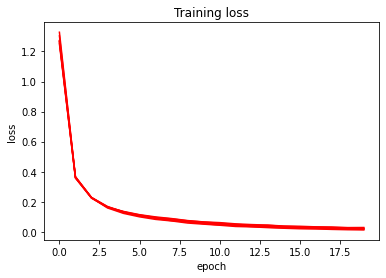

In [ ]:
# Fixing the effective dropout rate and varying the layer mask size

list_proportion_prob = [0.55, 0.65, 0.75, 0.85, 0.95, 1]

for prob in list_proportion_prob:
  dropoutHL = 0.35/prob
  dropout_input = 0.14/prob

  class MLP1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes , method='standard', prob_mask_prop = 1 ):
        super(MLP1, self).__init__()

        self.hidden_layer1 = nn.Linear(input_size, hidden_size)
        #torch.nn.init.kaiming_normal(self.hidden_layer1.weight, a=1, mode='fan_in')
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        #torch.nn.init.kaiming_normal(self.hidden_layer2.weight, a=1,  mode='fan_in')
        self.hidden_layer3 = nn.Linear(hidden_size, hidden_size)
        #torch.nn.init.kaiming_normal(self.hidden_layer3.weight, a=1, mode='fan_in')
        self.output_layer = nn.Linear(hidden_size, num_classes)
        #torch.nn.init.kaiming_normal(self.output_layer.weight, a=1, mode='fan_in')
        #self.custom_dropout = CustomDropout(p=0.5, prob_mask_prop=1 )
        self.dropout_input = CustomDropout(p=dropout_input, prob_mask_prop=prob_mask_prop , method=method )
        self.dropout_HL = CustomDropout(p=dropoutHL, prob_mask_prop=prob_mask_prop , method=method ) 
        #self.dropout_input = nn.Dropout(0.2)
        #self.dropout_HL = nn.Dropout(0.5) 
    
    def forward(self, x):  
        x = self.dropout_input(x)      
        out = F.relu(self.hidden_layer1(x))
        out = self.dropout_HL(out)
        out = F.relu(self.hidden_layer2(out))
        out = self.dropout_HL(out)
        out = F.relu(self.hidden_layer3(out))
        out = self.dropout_HL(out)
        out = self.output_layer(out)
        return out

  model1 = MLP1(input_size, hidden_size, num_classes, method='standard', prob_mask_prop = prob)

  # If GPU is available, move the model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model1.to(device)

  print(f"Network Architecture: \n {model1}")
  #print(f"The model is at : {device}")

  loss_func = nn.CrossEntropyLoss()  
  optimizer = torch.optim.SGD(model1.parameters(), lr=1e-3, momentum=0.9)


  initial_momentum = 0.50
  final_momentum = 0.95
  momentum_change_steps = 1000

  base_epsilon = 0.02
  epsilon_decay_half_life = 5000

  step = 0  # Step count

  losses = []
  model1.train()
  for epoch in range(20):
      epoch_loss = []

      # Iterate over data
      for batch_idx, (images, labels) in enumerate(train_loader):  
        #move tensor to the same device (CPU/GPU) as the model
        images, labels = images.to(device), labels.to(device)
      
        # Flatten the images
        images = images.view(-1, 28*28)
      
        # Zero the parameter gradients
        optimizer.zero_grad()  
      
        # forward + loss calc + backward + step
        outputs = model1(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        #test_lr_scheduler.step()
      
        max_norm(model1, 3.5)

        momentum = final_momentum - (final_momentum - initial_momentum)*np.exp(-float(step)/momentum_change_steps)
        update_optim(optimizer, momentum, 'momentum')

        #epsilon = base_epsilon / (1 + float(step) / epsilon_decay_half_life)
        epsilon = base_epsilon / np.power(2, float(step) / epsilon_decay_half_life)
        update_optim(optimizer, epsilon, 'lr')
      

        step += 1

        #if batch_idx % 600 == 0:
        #  print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

        epoch_loss.append(loss.item())
      losses.append(np.mean(epoch_loss))

  plt.plot(np.arange(len(losses)), losses, 'r')
  plt.title('Training loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')

  correct = 0
  total = 0
  model1.eval()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          images = images.view(-1, 28*28)
          outputs = model1(images)
          _, predicted = torch.max(outputs.data, dim=1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f"Test Accuracy: {(100 * correct / total)} %")

In [ ]:
# Varying the dropout rate with full max (regular dropout)

list_proportion_prob = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for prob in list_proportion_prob:
  dropoutHL = 0.5*prob
  dropout_input = 0.2*prob

  class MLP1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes , method='standard', prob_mask_prop = 1 ):
        super(MLP1, self).__init__()

        self.hidden_layer1 = nn.Linear(input_size, hidden_size)
        #torch.nn.init.kaiming_normal(self.hidden_layer1.weight, a=1, mode='fan_in')
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        #torch.nn.init.kaiming_normal(self.hidden_layer2.weight, a=1,  mode='fan_in')
        self.hidden_layer3 = nn.Linear(hidden_size, hidden_size)
        #torch.nn.init.kaiming_normal(self.hidden_layer3.weight, a=1, mode='fan_in')
        self.output_layer = nn.Linear(hidden_size, num_classes)
        #torch.nn.init.kaiming_normal(self.output_layer.weight, a=1, mode='fan_in')
        #self.custom_dropout = CustomDropout(p=0.5, prob_mask_prop=1 )
        self.dropout_input = CustomDropout(p=dropout_input, prob_mask_prop=prob_mask_prop , method=method )
        self.dropout_HL = CustomDropout(p=dropoutHL, prob_mask_prop=prob_mask_prop , method=method ) 
        #self.dropout_input = nn.Dropout(0.2)
        #self.dropout_HL = nn.Dropout(0.5) 
    
    def forward(self, x):  
        x = self.dropout_input(x)      
        out = F.relu(self.hidden_layer1(x))
        out = self.dropout_HL(out)
        out = F.relu(self.hidden_layer2(out))
        out = self.dropout_HL(out)
        out = F.relu(self.hidden_layer3(out))
        out = self.dropout_HL(out)
        out = self.output_layer(out)
        return out

  model1 = MLP1(input_size, hidden_size, num_classes, method='standard', prob_mask_prop = 1)

  # If GPU is available, move the model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model1.to(device)

  print(f"Network Architecture: \n {model1}")
  #print(f"The model is at : {device}")

  loss_func = nn.CrossEntropyLoss()  
  optimizer = torch.optim.SGD(model1.parameters(), lr=1e-3, momentum=0.9)


  initial_momentum = 0.50
  final_momentum = 0.95
  momentum_change_steps = 1000

  base_epsilon = 0.02
  epsilon_decay_half_life = 5000

  step = 0  # Step count

  losses = []
  model1.train()
  for epoch in range(20):
      epoch_loss = []

      # Iterate over data
      for batch_idx, (images, labels) in enumerate(train_loader):  
        #move tensor to the same device (CPU/GPU) as the model
        images, labels = images.to(device), labels.to(device)
      
        # Flatten the images
        images = images.view(-1, 28*28)
      
        # Zero the parameter gradients
        optimizer.zero_grad()  
      
        # forward + loss calc + backward + step
        outputs = model1(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        #test_lr_scheduler.step()
      
        max_norm(model, 3.5)

        momentum = final_momentum - (final_momentum - initial_momentum)*np.exp(-float(step)/momentum_change_steps)
        update_optim(optimizer, momentum, 'momentum')

        #epsilon = base_epsilon / (1 + float(step) / epsilon_decay_half_life)
        epsilon = base_epsilon / np.power(2, float(step) / epsilon_decay_half_life)
        update_optim(optimizer, epsilon, 'lr')
      

        step += 1

        #if batch_idx % 600 == 0:
        #  print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

        epoch_loss.append(loss.item())
      losses.append(np.mean(epoch_loss))

  plt.plot(np.arange(len(losses)), losses, 'r')
  plt.title('Training loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')

  correct = 0
  total = 0
  model1.eval()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          images = images.view(-1, 28*28)
          outputs = model1(images)
          _, predicted = torch.max(outputs.data, dim=1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f"Test Accuracy: {(100 * correct / total)} %")

**MODEL B**

In [ ]:
class MLP1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, method='standard', prob_mask_prop = 1 ):
        super(MLP1, self).__init__()

        self.hidden_layer1 = nn.Linear(input_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer3 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.custom_dropout_HL = CustomDropout(p=0.5, prob_mask_prop=prob_mask_prop , method=method )
        self.custom_dropout_input = CustomDropout(p=0.2, prob_mask_prop=prob_mask_prop, method=method )
        #self.dropout_input = nn.Dropout(0.2)
        #self.dropout_HL = nn.Dropout(0.5) 
    
    def forward(self, x):  
        x = self.custom_dropout_input(x)      
        out = F.relu(self.hidden_layer1(x))
        out = self.custom_dropout_HL(out)
        out = F.relu(self.hidden_layer2(out))
        out = self.custom_dropout_HL(out)
        out = F.relu(self.hidden_layer3(out))
        out = self.custom_dropout_HL(out)
        out = self.output_layer(out)
        return out


In [ ]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
list_proportion_prob = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for prob in list_proportion_prob:
  model1 = MLP1(input_size, hidden_size, num_classes, method='standard', prob_mask_prop = prob)

  # If GPU is available, move the model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model1.to(device)

  print(f"Network Architecture: \n {model1}")
  #print(f"The model is at : {device}")

  loss_func = nn.CrossEntropyLoss()  
  optimizer = torch.optim.SGD(model1.parameters(), lr=1e-3, momentum=0.9)

  #initial_momentum = 0.5
  #final_momentum = 0.95
  #momentum_change_steps = 5000
  step = 0  # Step count

  losses = []
  model1.train()
  for epoch in range(50):
      epoch_loss = []

      # Iterate over data
      for batch_idx, (images, labels) in enumerate(train_loader):  
        #move tensor to the same device (CPU/GPU) as the model
        images, labels = images.to(device), labels.to(device)
      
        # Flatten the images
        images = images.view(-1, 28*28)
      
        # Zero the parameter gradients
        optimizer.zero_grad()  
      
        # forward + loss calc + backward + step
        outputs = model1(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        #test_lr_scheduler.step()

      
      
        #momentum = final_momentum - (final_momentum - initial_momentum)*np.exp(-float(step)/momentum_change_steps)
        #update_optim(optimizer, momentum, 'momentum')
      

        step += 1

        #if batch_idx % 600 == 0:
        #  print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

        epoch_loss.append(loss.item())
      losses.append(np.mean(epoch_loss))

  plt.plot(np.arange(len(losses)), losses, 'r')
  plt.title('Training loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')

  correct = 0
  total = 0
  model1.eval()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          images = images.view(-1, 28*28)
          outputs = model1(images)
          _, predicted = torch.max(outputs.data, dim=1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f"Test Accuracy: {(100 * correct / total)} %")

In [ ]:
list_proportion_prob = [0.55, 0.65, 0.75, 0.85, 0.95, 1]

for prob in list_proportion_prob:
  dropoutHL = 0.5/prob
  dropout_input = 0.2/prob
  class MLP1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, method='standard', prob_mask_prop = 1 ):
        super(MLP1, self).__init__()

        self.hidden_layer1 = nn.Linear(input_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer3 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.custom_dropout_HL = CustomDropout(p=dropoutHL, prob_mask_prop=prob_mask_prop , method=method )
        self.custom_dropout_input = CustomDropout(p=dropout_input, prob_mask_prop=prob_mask_prop, method=method )
        #self.dropout_input = nn.Dropout(0.2)
        #self.dropout_HL = nn.Dropout(0.5) 
    
    def forward(self, x):  
        x = self.custom_dropout_input(x)      
        out = F.relu(self.hidden_layer1(x))
        out = self.custom_dropout_HL(out)
        out = F.relu(self.hidden_layer2(out))
        out = self.custom_dropout_HL(out)
        out = F.relu(self.hidden_layer3(out))
        out = self.custom_dropout_HL(out)
        out = self.output_layer(out)
        return out

  model1 = MLP1(input_size, hidden_size, num_classes, method='standard', prob_mask_prop = prob)

  # If GPU is available, move the model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model1.to(device)

  print(f"Network Architecture: \n {model1}")
  #print(f"The model is at : {device}")

  loss_func = nn.CrossEntropyLoss()  
  optimizer = torch.optim.SGD(model1.parameters(), lr=1e-3, momentum=0.9)

  #initial_momentum = 0.5
  #final_momentum = 0.95
  #momentum_change_steps = 5000
  step = 0  # Step count

  losses = []
  model1.train()
  for epoch in range(50):
      epoch_loss = []

      # Iterate over data
      for batch_idx, (images, labels) in enumerate(train_loader):  
        #move tensor to the same device (CPU/GPU) as the model
        images, labels = images.to(device), labels.to(device)
      
        # Flatten the images
        images = images.view(-1, 28*28)
      
        # Zero the parameter gradients
        optimizer.zero_grad()  
      
        # forward + loss calc + backward + step
        outputs = model1(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        #test_lr_scheduler.step()

      
      
        #momentum = final_momentum - (final_momentum - initial_momentum)*np.exp(-float(step)/momentum_change_steps)
        #update_optim(optimizer, momentum, 'momentum')
      

        step += 1

        #if batch_idx % 600 == 0:
        #  print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

        epoch_loss.append(loss.item())
      losses.append(np.mean(epoch_loss))

  plt.plot(np.arange(len(losses)), losses, 'r')
  plt.title('Training loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')

  correct = 0
  total = 0
  model1.eval()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          images = images.view(-1, 28*28)
          outputs = model1(images)
          _, predicted = torch.max(outputs.data, dim=1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f"Test Accuracy: {(100 * correct / total)} %")

In [ ]:
list_proportion_prob = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for prob in list_proportion_prob:
  dropoutHL = 0.35*prob
  dropout_input = 0.14*prob
  class MLP1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, method='standard', prob_mask_prop = 1 ):
        super(MLP1, self).__init__()

        self.hidden_layer1 = nn.Linear(input_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer3 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.custom_dropout_HL = CustomDropout(p=dropoutHL, prob_mask_prop=prob_mask_prop , method=method )
        self.custom_dropout_input = CustomDropout(p=dropout_input, prob_mask_prop=prob_mask_prop, method=method )
        #self.dropout_input = nn.Dropout(0.2)
        #self.dropout_HL = nn.Dropout(0.5) 
    
    def forward(self, x):  
        x = self.custom_dropout_input(x)      
        out = F.relu(self.hidden_layer1(x))
        out = self.custom_dropout_HL(out)
        out = F.relu(self.hidden_layer2(out))
        out = self.custom_dropout_HL(out)
        out = F.relu(self.hidden_layer3(out))
        out = self.custom_dropout_HL(out)
        out = self.output_layer(out)
        return out

  model1 = MLP1(input_size, hidden_size, num_classes, method='standard', prob_mask_prop = 1)

  # If GPU is available, move the model to GPU
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model1.to(device)

  print(f"Network Architecture: \n {model1}")
  #print(f"The model is at : {device}")

  loss_func = nn.CrossEntropyLoss()  
  optimizer = torch.optim.SGD(model1.parameters(), lr=1e-3, momentum=0.9)

  #initial_momentum = 0.5
  #final_momentum = 0.95
  #momentum_change_steps = 5000
  step = 0  # Step count

  losses = []
  model1.train()
  for epoch in range(50):
      epoch_loss = []

      # Iterate over data
      for batch_idx, (images, labels) in enumerate(train_loader):  
        #move tensor to the same device (CPU/GPU) as the model
        images, labels = images.to(device), labels.to(device)
      
        # Flatten the images
        images = images.view(-1, 28*28)
      
        # Zero the parameter gradients
        optimizer.zero_grad()  
      
        # forward + loss calc + backward + step
        outputs = model1(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        #test_lr_scheduler.step()

      
      
        #momentum = final_momentum - (final_momentum - initial_momentum)*np.exp(-float(step)/momentum_change_steps)
        #update_optim(optimizer, momentum, 'momentum')
      

        step += 1

        #if batch_idx % 600 == 0:
        #  print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

        epoch_loss.append(loss.item())
      losses.append(np.mean(epoch_loss))

  plt.plot(np.arange(len(losses)), losses, 'r')
  plt.title('Training loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')

  correct = 0
  total = 0
  model1.eval()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          images = images.view(-1, 28*28)
          outputs = model1(images)
          _, predicted = torch.max(outputs.data, dim=1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f"Test Accuracy: {(100 * correct / total)} %")

Network Architecture: 
 MLP1(
  (hidden_layer1): Linear(in_features=784, out_features=1024, bias=True)
  (hidden_layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (hidden_layer3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=10, bias=True)
  (custom_dropout_HL): CustomDropout(p=0.0 , prob_mask_prop=1 , method=standard)
  (custom_dropout_input): CustomDropout(p=0.0 , prob_mask_prop=1 , method=standard)
)
Test Accuracy: 97.74 %
Network Architecture: 
 MLP1(
  (hidden_layer1): Linear(in_features=784, out_features=1024, bias=True)
  (hidden_layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (hidden_layer3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=10, bias=True)
  (custom_dropout_HL): CustomDropout(p=0.034999999999999996 , prob_mask_prop=1 , method=standard)
  (custom_dropout_input): CustomDropout(p=0.014000000000000002 , pro

# CIFAR10 Experiments (unused)

Dataloading

In [ ]:
#CIFAR10 dataloading
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_loader = DataLoader(trainset, batch_size=len(trainset))
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = (images.numpy()).transpose(0,2,3,1)
images = images.reshape(-1, 3072)
images = images - images.mean(axis=0)

In [ ]:
#Preprocessing training set example
zca_data = np.zeros(3072) #Temporarily add initial row of zeros so vstack works
for i in range(5):
  images_temp = images[i*10000:(i+1)*10000]
  # compute the covariance of the image data
  cov = np.cov(images_temp, rowvar=True)   # cov is (N, N)
  # singular value decomposition
  U,S,V = np.linalg.svd(cov)     # U is (N, N), S is (N,)
  # build the ZCA matrix
  epsilon = 1e-5
  zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
  # transform the image data       zca_matrix is (N,N)
  zca = np.dot(zca_matrix, images_temp)    # zca is (N, 3072)
  for j in range(10000):
    zca_data = np.vstack((zca_data,zca[j]))
zca_data = zca_data[1:50002]
zca_data_resized = zca_data.reshape(-1,3,32,32)
tensor_x = torch.Tensor(zca_data_resized)

Model

In [ ]:
#CNN
class CNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, 5, padding=2) 
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 5, padding=2)
        self.fc1 = nn.Linear(256*3*3, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 10)
        if config['activation'] == 'ReLU':
            self.activation = nn.ReLU()
        elif config['activation'] == 'leaky_ReLU':
            self.activation = nn.LeakyReLU(negative_slope=0.1)
        self.dropout1 = nn.Dropout(p=config['dropout'][0])
        self.dropout2 = nn.Dropout(p=config['dropout'][1])
        self.dropout3 = nn.Dropout(p=config['dropout'][2])
        self.dropout4 = nn.Dropout(p=config['dropout'][3])
        self.dropout5 = nn.Dropout(p=config['dropout'][4])
        self.dropout6 = nn.Dropout(p=config['dropout'][5])

    def forward(self, x):
        x = self.dropout1(x)
        x = self.pool(self.activation(self.conv1(x)))
        x = self.dropout2(x)
        x = self.pool(self.activation(self.conv2(x)))
        x = self.dropout3(x)
        x = self.pool(self.activation(self.conv3(x)))
        x = self.dropout4(x)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.activation(self.fc1(x))
        x = self.dropout5(x)
        x = self.activation(self.fc2(x))
        x = self.dropout6(x)
        x = self.fc3(x)
        return x

Experiments

In [ ]:
#Table 4: CNN without dropout
config = {
    'batch_size': (264,),
    'early_stopping': (True,),
    'max_epochs': (500,),
    'max_steps': (None,),  # If None need to specify max_epochs
    'momentum': (0.95,),
    'momentum_decay': (True,), # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': (0.5,),
    'final_momentum': (0.95,),
    'momentum_change_steps': (20000,), # Number of steps at which 'final_momentum' is set
    'learning_rate': (0.25,0.1,0.01,0.001), # (0.25, 1e-1, 1e-2),
    'epsilon_decay': ('EXPONENTIAL',), # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1,),
    'epsilon_decay_half_life': (100000,),
    'L2_regularization_param': (0,),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': ([0,0,0,0,0,0],), # Implement your models with each layer's p in a list
    'activation': ('ReLU',),
    'D_in': (32*32,),
    'D_h': ([0],), # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,), # Number of classes
    'max_norm': (2,),  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'CNN' # MLP or CNN
}
train_test(trainset, testset, config, RAND, k_folds=0.1, random_search_samples=4, verbose=True, plot_acc=False)

In [ ]:
#Table 4: CNN with dropout only in fully connected layers
config = {
    'batch_size': (264,),
    'early_stopping': (True,),
    'max_epochs': (500,),
    'max_steps': (None,),  # If None need to specify max_epochs
    'momentum': (0.95,),
    'momentum_decay': (True,), # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': (0.5,),
    'final_momentum': (0.95,),
    'momentum_change_steps': (20000,), # Number of steps at which 'final_momentum' is set
    'learning_rate': (0.25,0.1,0.01,0.001), # (0.25, 1e-1, 1e-2),
    'epsilon_decay': ('EXPONENTIAL',), # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1,),
    'epsilon_decay_half_life': (100000,),
    'L2_regularization_param': (0,),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': ([0,0,0,0,0.5,0.5],), # Implement your models with each layer's p in a list
    'activation': ('ReLU',),
    'D_in': (32*32,),
    'D_h': ([0],), # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,), # Number of classes
    'max_norm': (2,),  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'CNN' # MLP or CNN
}
train_test(trainset, testset, config, RAND, k_folds=0.1, random_search_samples=4, verbose=True, plot_acc=False)

In [ ]:
#Table 4: CNN with dropout in all layers
config = {
    'batch_size': (264,),
    'early_stopping': (True,),
    'max_epochs': (500,),
    'max_steps': (None,),  # If None need to specify max_epochs
    'momentum': (0.95,),
    'momentum_decay': (True,), # If True will use 'initial_momentum' and 'final_momentum' according to schedule, if False will use 'momentum'
    'initial_momentum': (0.5,),
    'final_momentum': (0.95,),
    'momentum_change_steps': (20000,), # Number of steps at which 'final_momentum' is set
    'learning_rate': (0.25,0.1,0.01,0.001), # (0.25, 1e-1, 1e-2),
    'epsilon_decay': ('EXPONENTIAL',), # EXPONENTIAL OR INVERSE_T, for learning rate decay, False for static learning rate
    'base_epsilon': (0.1,),
    'epsilon_decay_half_life': (100000,),
    'L2_regularization_param': (0,),
    'L1_regularization_param': 0.0,
    'L1_start_step': 150000,
    'kl_sparsity': None,  # KL Sparsity rho
    'kl_sparsity_beta': 0.0,  # beta coefficient for regularization term
    'dropout': ([0.9,0.75,0.75,0.5,0.5,0.5],), # Implement your models with each layer's p in a list
    'activation': ('ReLU',),
    'D_in': (32*32,),
    'D_h': ([0],), # Width of each hidden layer inside a list, if D_h[0] is 0 then no hidden layers
    'D_out': (10,), # Number of classes
    'max_norm': (2,),  # (4, 3, 2, 1, 0.5, None] # Max norm contraint from dropout paper on the weights
    'model_type': 'CNN' # MLP or CNN
}
train_test(trainset, testset, config, RAND, k_folds=0.1, random_search_samples=4, verbose=True, plot_acc=False)